# Python vs Alteryx Machine Learning Tools
## Project 1: Multiple Linear Regression

#### Scenario:
In this project, we will analyze a business problem in the mail-order catalog business. We've been tasked with predicting how much money our company can expect to earn from sending out a catalog to new customers. This task will involve building the model and applying the results in order to provide a recommendation to management.

#### The Business Problem:
We recently started working for a company that manufactures and sells high-end home goods. Last year the company sent out its first print catalog, and is preparing to send out this year's catalog in the coming months. The company has 250 new customers from their mailing list that they want to send the catalog to.

Our manager has been asked to determine how much profit the company can expect from sending a catalog to these customers. We, the data analysts, are assigned to help the manager run the numbers. While fairly knowledgeable about data analysis, our manager is not very familiar with predictive models.

Hence, we’ve been asked to predict the expected profit from these 250 new customers. Management does not want to send the catalog out to these new customers unless the expected profit contribution exceeds 10,000 Dollars.

#### Details:
 - The costs of printing and distributing is 6.50 Dollars per catalog.
 - The average gross margin (price - cost) on all products sold through the catalog is 50%.
 - The datasets have been preprocessed and does not require data cleaning nor deal with missing values

### Getting Started

In [1]:
# Import the basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import the datasets
old_customers = pd.read_csv("p1-customers.csv")
new_customers = pd.read_excel("p1-mailinglist.xlsx")

In [2]:
# Inspect both datasets to understand them better
old_customers.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,#_Years_as_Customer,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,Avg_Sale_Amount
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,6,100,No,1,227.90
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,6,105,Yes,1,55.00
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,3,101,No,1,212.57
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,6,105,Yes,1,195.31
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,2,100,Yes,1,110.55


In [3]:
new_customers.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706


##### Observation:
 - The old customer dataset contains 12 columns and the new customer dataset contains also 12 columns

 - The old customer dataset contains a column, "Responded_to_Last_Catalog", which is not present in the new customer dataset as the new customers have not yet received any catalos as of yet. We are here to determine whether to send these new customers any catalogs. Hence, this column should be dropped.

 - Another column which is not present in the new customer dataset is "Avg_Sale_Amount", which will be our target variable that we will predict in order to determine if it would be profitable enough to send the catalogs.

 - This leaves us with 10 potential predictor variables from the training set based on our old customers' buying behaviour, yet there are 12 variables in the new customer dataset. As you can see there are two additional columns, "Score_No" and "Score_Yes". These two columns predict the likelihood of these new customers spending X amount and will help us to determine a more realistic estimate of profits.

 - Furthermore, we can drop the following variables from both datasets as they hold no bearing on customer buying behaviour: Name, Customer_ID, Address and State, as all customers are from Colorado.

In [4]:
# Drop the unnecessary variables from the training dataset for better computation, even more important for very large dataset
old_customers = old_customers.drop(["Name", "Customer_ID", "Address", "State", "Responded_to_Last_Catalog"], axis = 1)

# Check the updated dataframe
old_customers.head()

,Customer_Segment,City,ZIP,#_Years_as_Customer,Store_Number,Avg_Num_Products_Purchased,Avg_Sale_Amount
0,Store Mailing List,Denver,80224,6,100,1,227.90
1,Store Mailing List,Greenwood Village,80111,6,105,1,55.00
2,Store Mailing List,Centennial,80122,3,101,1,212.57
3,Store Mailing List,Denver,80239,6,105,1,195.31
4,Store Mailing List,Denver,80206,2,100,1,110.55


### General Checks 

In [5]:
# Familiarize yourself with the dataset and check for any missing values just in case
old_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 7 columns):
Customer_Segment              2375 non-null object
City                          2375 non-null object
ZIP                           2375 non-null int64
#_Years_as_Customer           2375 non-null int64
Store_Number                  2375 non-null int64
Avg_Num_Products_Purchased    2375 non-null int64
Avg_Sale_Amount               2375 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 130.0+ KB


##### Observation:
 - All is fine in terms of missing values, as there are no Null values in this dataset. 
 - The object values indicate some of the categorical variables present in our dataset.
 - ZIP, Years_as_Customer, Store_Number and Avg_Sale_Amount are listed as integers. However, ZIP and Store_Number are also categorical variables as each feature is a discrete value, as well as Years_as_Customer which will be demonstrated further shortly.
 - Our target variable, Avg_Sale_Amount, is represented as a float for it is continuous variable representing money.

In [6]:
# Understand the dataset further via its statistical make-up
old_customers.describe()

,ZIP,#_Years_as_Customer,Store_Number,Avg_Num_Products_Purchased,Avg_Sale_Amount
count,2375.000000,2375.000000,2375.000000,2375.000000,2375.000000
mean,80123.333474,4.500632,104.297684,3.347368,399.774093
std,107.255770,2.309986,2.837240,2.738568,340.115808
min,80002.000000,1.000000,100.000000,1.000000,1.220000
25%,80014.000000,2.000000,101.000000,1.000000,168.925000
50%,80123.000000,5.000000,105.000000,3.000000,281.320000
75%,80221.000000,6.000000,107.000000,5.000000,572.400000
max,80640.000000,8.000000,109.000000,26.000000,2963.490000


##### Observations: 
 - 25% of Customers have been a customer up to two years
 - 50% of Customers have been a customer up to five years
 - 75% of Customers have been a customer up to six years
***
 - 25% of Customers purchased one product on average
 - 50% of Customers purchased up to three products on average
 - 75% of Customers purchased up to five products on average
***
 - 25% of Customers spent 168.93 Dollars (2dp) on average
 - 50% of Customers spent 281.32 Dollars (2dp) on average
 - 75% of Customers spent 572.40 Dollars (2dp) on average

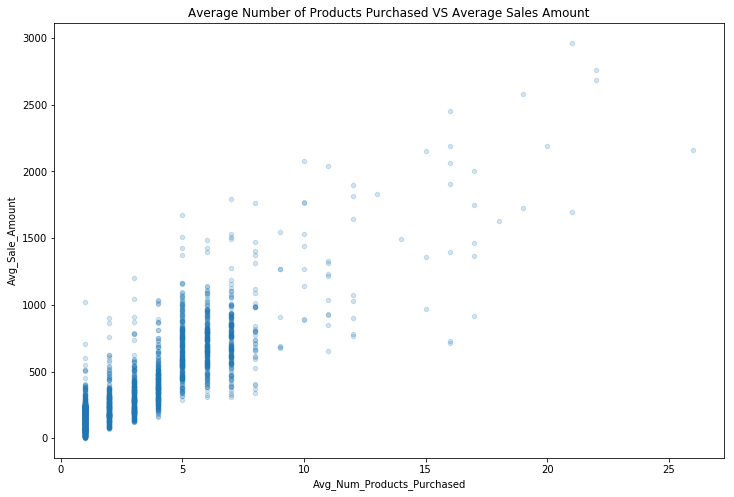

In [7]:
# Check for correlation between these two numerical attributes/features and our target variable "Avg_Sale_Amount"
# First "Avg_Num_Products_Purchased" vs "Avg_Sale_Amount"
old_customers.plot(kind = "scatter", x = "Avg_Num_Products_Purchased", y = "Avg_Sale_Amount", figsize = (12, 8), alpha = 0.2)
plt.title("Average Number of Products Purchased VS Average Sales Amount")
plt.show()

##### Observation: 
 - The scatter plot shows a direct correlation between the two variables that is positive as when "Avg_Sale_Amount" increases so does "Avg_Num_Products_Purchased". 
 - Furthermore, with the help of setting the 'alpha' parameter to 0.2 ('alpha' is a float value from 0.0 transparent through 1.0 opaque), we can see the density of the distributions that correspond with the quartile values obtained using the describe() method previously. 
***
 > PS: The parameter 'figsize' determines the size of the scatter plot - width by height. Try different values for 'alpha' and 'figsize'.

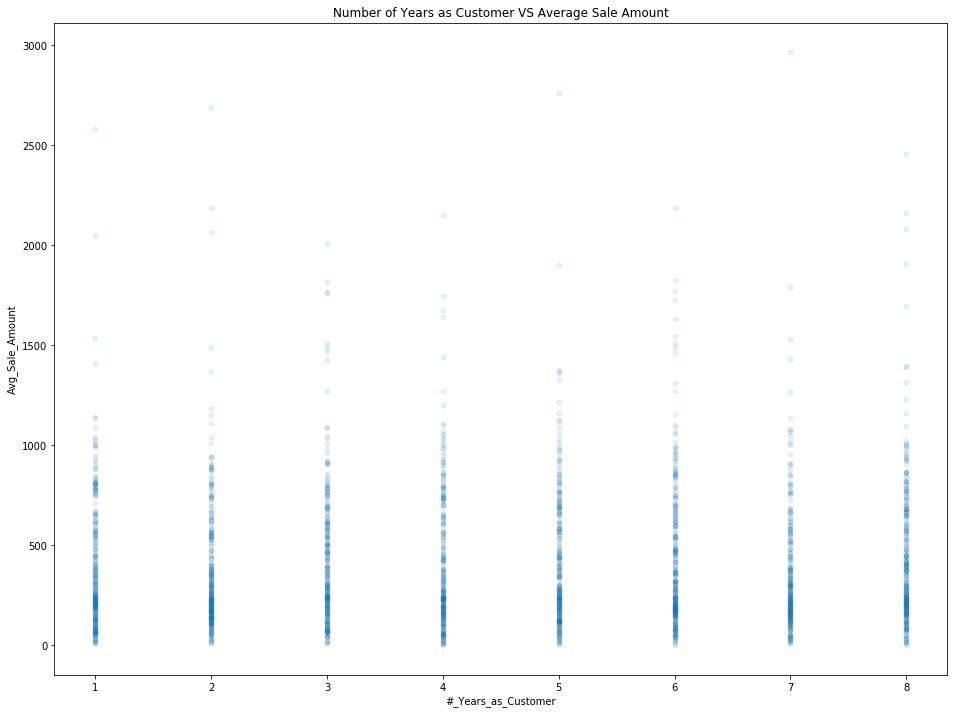

In [8]:
old_customers.plot(kind = "scatter", x = "#_Years_as_Customer", y = "Avg_Sale_Amount", figsize = (16,12), alpha = 0.1)
plt.title("Number of Years as Customer VS Average Sale Amount")
plt.show()

##### Observation:
 -  This scatter plot demonstrates that there is no linear relationship between ‘Average Sales Amount’ and ‘Years as Customer’, the Years are categorical variables rather than continuous values.

### Dealing with Categorical/Text Variables

In [9]:
# convert categorical values to dummy variables
old_customers_dv = pd.get_dummies(old_customers, columns = ["Customer_Segment","ZIP", "City", "#_Years_as_Customer", "Store_Number"], drop_first=True)
old_customers_dv.head()

,Avg_Num_Products_Purchased,Avg_Sale_Amount,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List,ZIP_80003,ZIP_80004,ZIP_80005,ZIP_80007,ZIP_80010,...,#_Years_as_Customer_8,Store_Number_101,Store_Number_102,Store_Number_103,Store_Number_104,Store_Number_105,Store_Number_106,Store_Number_107,Store_Number_108,Store_Number_109
0,1,227.90,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55.00,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,212.57,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,195.31,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,110.55,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
correlation = old_customers_dv.corr()
features = correlation["Avg_Sale_Amount"].sort_values(ascending = False)

In [11]:
features.head()

Avg_Sale_Amount                                  1.000000
Avg_Num_Products_Purchased                       0.855754
Customer_Segment_Loyalty Club and Credit Card    0.591488
City_Commerce City                               0.054125
ZIP_80022                                        0.054125
Name: Avg_Sale_Amount, dtype: float64

In [12]:
features.tail()

Store_Number_108                      -0.037040
#_Years_as_Customer_2                 -0.037814
#_Years_as_Customer_7                 -0.039627
ZIP_80134                             -0.040220
Customer_Segment_Store Mailing List   -0.666655
Name: Avg_Sale_Amount, dtype: float64

##### Observation
'Avg_Num_Products_Purchased', 'Customer_Segment_Loyalty Club and Credit Card' and 'Customer_Segment_Store Mailing List' have the most significant correlation with 'Avg_Sale_Amount'. Therefore, the rest of the variables will be excluded from our feature selection, however we will include all customer segments as one of the dummy variables was dropped to avoid the dummy variable trap.

In [13]:
# Update the dataset with the selected features & Update dummy variables
old_customers = old_customers.drop(["ZIP", "City", "#_Years_as_Customer", "Store_Number"], axis = 1)
old_customers_dv = pd.get_dummies(old_customers, columns = ["Customer_Segment"], drop_first = True)

In [14]:
old_customers_dv.head()

,Avg_Num_Products_Purchased,Avg_Sale_Amount,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List
0,1,227.90,0,0,1
1,1,55.00,0,0,1
2,1,212.57,0,0,1
3,1,195.31,0,0,1
4,1,110.55,0,0,1


In [15]:
# split the dataset into the training and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(old_customers_dv, test_size=0.3, random_state = 0)
train.head()

,Avg_Num_Products_Purchased,Avg_Sale_Amount,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List
2136,5,657.55,0,0,0
1151,16,2455.90,0,1,0
227,1,16.25,0,0,1
1757,6,466.27,1,0,0
2273,5,681.80,0,0,0


In [16]:
test.head()

,Avg_Num_Products_Purchased,Avg_Sale_Amount,Customer_Segment_Loyalty Club Only,Customer_Segment_Loyalty Club and Credit Card,Customer_Segment_Store Mailing List
251,1,172.71,0,0,1
733,1,80.25,0,0,1
361,1,138.49,0,0,1
1129,7,1492.45,0,1,0
391,1,112.99,0,0,1


In [17]:
X_train = train.loc[:, ["Avg_Num_Products_Purchased", "Customer_Segment_Loyalty Club Only", "Customer_Segment_Loyalty Club and Credit Card", "Customer_Segment_Store Mailing List"]].values
y_train = train.iloc[:, 1].values

X_test = test.loc[:, ["Avg_Num_Products_Purchased", "Customer_Segment_Loyalty Club Only", "Customer_Segment_Loyalty Club and Credit Card", "Customer_Segment_Store Mailing List"]].values
y_test = test.iloc[:, 1].values

## Multiple Linear Regression with Scikit's LinearRegression()
### Basic Linear Regression

In [18]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

Coefficients: 
 [  66.60740773 -150.49748774  283.80063958 -247.33711254]


In [20]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

Mean squared error: 16734.12


In [21]:
# Explained variance score: 1 is perfect prediction
print("R2 Score: %.4f"% r2_score(y_test, y_pred))

R2 Score: 0.8318


## Multiple Linear Regression with Scikit's SDGRegressor()
### Stochastic Gradient Descent

In [22]:
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor(max_iter = 400, penalty = None, eta0 = 0.01)
regressor.fit(X_train,y_train.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=400, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [24]:
# The coefficients
print('Coefficients: \n', regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print("R2 Score: %.4f"% r2_score(y_test, y_pred))

Coefficients: 
 [  66.63226248 -150.41753824  284.40051269 -246.96981047]
Mean squared error: 16734.12
R2 Score: 0.8318


## Multiple Linear Regression with Scikit's SDGRegressor () with l2 penalty
### Ridge Regression

In [25]:
regressor = SGDRegressor(max_iter = 400, penalty = "l2", eta0 = 0.01)
regressor.fit(X_train,y_train.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=400, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [26]:
y_pred = regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print("R2 Score: %.4f"
      % r2_score(y_test, y_pred))

Coefficients: 
 [  69.39984764 -149.94056106  283.98427518 -246.75170034]
Mean squared error: 16944.42
R2 Score: 0.8297


## Multiple Linear Regression with Scikit's SDGRegressor () with l1 penalty
### Lasso Regression

In [27]:
regressor = SGDRegressor(max_iter = 400, penalty = "l1", eta0 = 0.01)
regressor.fit(X_train,y_train.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=400, n_iter=None, penalty='l1',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [28]:
y_pred = regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print("R2 Score: %.4f"
      % r2_score(y_test, y_pred))

Coefficients: 
 [  67.96934333 -150.11762602  284.03843966 -247.08157061]
Mean squared error: 16807.39
R2 Score: 0.8311


## Multiple Linear Regression with Scikit's ElasticNet()
### Elastic Net Regression

In [29]:
from sklearn.linear_model import ElasticNet

regressor = ElasticNet(alpha = 0.01, l1_ratio = 0.9)
regressor.fit(X_train,y_train.ravel())

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
y_pred = regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print("R2 Score: %.4f"
      % r2_score(y_test, y_pred))

Coefficients: 
 [  67.09418552 -148.23834402  280.20203185 -244.1930276 ]
Mean squared error: 16728.55
R2 Score: 0.8319


## Multiple Linear Regression with Statsmodel's OLS()
### Ordinary Least Squares

In [32]:
# OLS does not support test sets
X = old_customers_dv.loc[:, ["Avg_Num_Products_Purchased", "Customer_Segment_Loyalty Club Only", "Customer_Segment_Loyalty Club and Credit Card", "Customer_Segment_Store Mailing List"]].values
y = old_customers_dv.iloc[:, 1].values

In [34]:
import statsmodels.api as sm

X_constant = sm.add_constant(X)
regressor = sm.OLS(y, X_constant)
ols = regressor.fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3040.
Date:                Mon, 29 Jan 2018   Prob (F-statistic):               0.00
Time:                        15:58:33   Log-Likelihood:                -15061.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2370   BIC:                         3.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        303.4635     10.576     28.694      0.000     282.725     324.202
x1            66.9762      1.515     44.208      0.000      64.005      69.947
x2          -149.3557      8.973    -16.645      0.000    -166.951    -131.760
x3           281.8388     11.910     23.664      0.000     258.484     305.194
x4          -245.4177      9.768    -25.125      0.000    -264.572    -226.263
==============================================================================
Omnibus:                      359.638   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4770.580
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""